Dataset Overview

The dataset used for this analysis is the Esophageal Carcinoma (TCGA PanCancer Atlas 2018) clinical data. It contains 182 patient records with various clinical and genomic features such as Diagnosis Age, Mutation Count, Fraction Genome Altered, and specific scores like MSI MANTIS and TMB. The primary objective is to build a Genomic Model to predict the Overall Survival Status (Living vs. Deceased).

Given the tabular nature of the genomic data and the requirement for image-based processing, we have employed a feature transformation technique. We select 9 key genomic and clinical features, normalize them, and reshape each patient's feature vector into a 3x3 pixel "Genomic Image". This allows us to utilize a Convolutional Neural Network (CNN) to capture patterns in the feature interactions. We also address the class imbalance in the target variable to ensure robust model training.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, Input

# Set style for plots
sns.set(style="whitegrid")
# Update this path to your local file location if needed
dataset_path = r'E:\NLP\Assignment\1&2\Esophageal_Cancer_Project\Data\Genomic\esca_tcga_pan_can_atlas_2018_clinical_data.tsv'

Cell 2: Data Loading, Preprocessing, and "Image" Creation
Here we load the data, select 9 key features, encode categorical variables, and reshape the normalized features into a 3x3 grid (Image Resolution Correction).

New Data Shape: (182, 4, 4, 1)


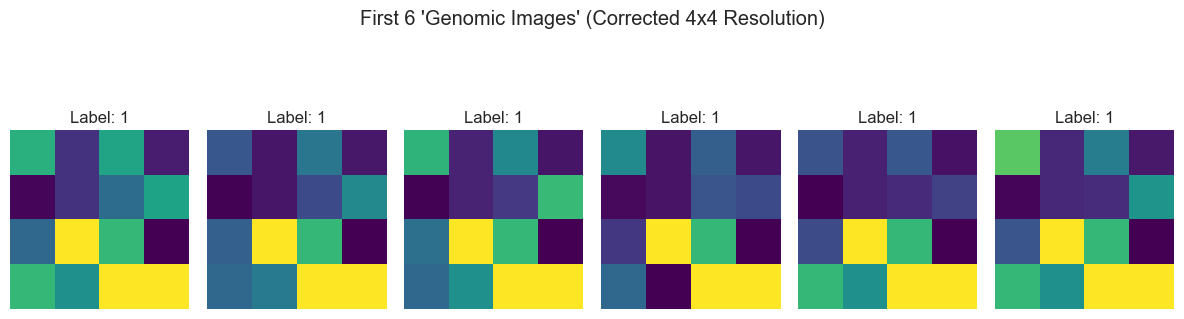

In [19]:
# Load Data
df = pd.read_csv(dataset_path, sep='\t')

# 1. Feature Selection (Selecting 16 features for a 4x4 Image)
# We combine 9 Numerical and 7 Categorical features to form a 16-pixel grid
features_num = [
    'Diagnosis Age', 'Mutation Count', 'Fraction Genome Altered',
    'MSI MANTIS Score', 'MSIsensor Score', 'TMB (nonsynonymous)',
    'Tumor Break Load', 'Aneuploidy Score', 'Patient Weight'
]

features_cat = [
    'Sex', 'Race Category', 'Cancer Type Detailed',
    'Neoplasm Histologic Grade',
    'Neoplasm Disease Stage American Joint Committee on Cancer Code',
    'Person Neoplasm Cancer Status', 'Primary Lymph Node Presentation Assessment'
]

features = features_num + features_cat
target = 'Overall Survival Status'

# 2. Cleaning & Imputation
# Numerical: Fill with mean
for col in features_num:
    df[col] = df[col].fillna(df[col].mean())

# Categorical: Fill with 'Unknown' and Label Encode
le = LabelEncoder()
for col in features_cat:
    df[col] = df[col].fillna('Unknown').astype(str)
    df[col] = le.fit_transform(df[col])

# Drop rows where target is missing
df = df.dropna(subset=[target])

# 3. Encoding Target (0: LIVING, 1: DECEASED)
df['target_enc'] = df[target].apply(lambda x: 1 if 'DECEASED' in str(x).upper() else 0)

# 4. Normalization (Pixel Intensity 0-1)
scaler = MinMaxScaler()
X_data = scaler.fit_transform(df[features])
y_data = df['target_enc'].values

# 5. Reshape to Images (Samples, Height, Width, Channels)
# CORRECTED Resolution: 4x4 pixels (16 features)
X_images = X_data.reshape(-1, 4, 4, 1)

print(f"New Data Shape: {X_images.shape}")

# 6. Graph: First 6 Images (Updated for 4x4)
plt.figure(figsize=(12, 4))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(X_images[i].reshape(4,4), cmap='viridis', interpolation='nearest')
    plt.title(f"Label: {y_data[i]}")
    plt.axis('off')
plt.suptitle("First 6 'Genomic Images' (Corrected 4x4 Resolution)")
plt.tight_layout()
plt.show()

Cell 3: Handling Class Imbalance (Balancing)
The dataset is imbalanced. We use Oversampling (Resampling) to balance the minority class (Deceased) to match the majority class (Living).

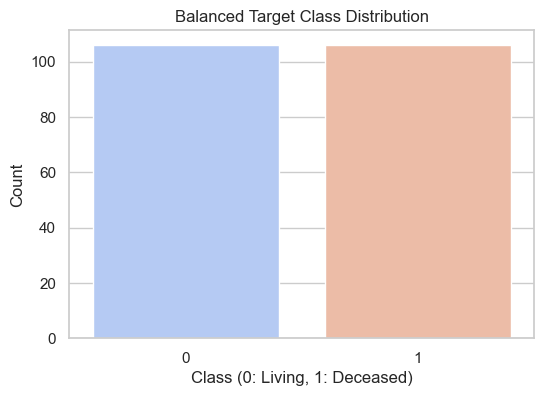

Training Data Shape: (169, 4, 4, 1)
Testing Data Shape: (43, 4, 4, 1)


In [20]:
# 1. Separate Majority and Minority Classes
# We use the dataframe 'df' from Cell 2
df_majority = df[df['target_enc'] == 0]
df_minority = df[df['target_enc'] == 1]

# 2. Upsample Minority Class
df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

# 3. Combine back
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# 4. Prepare Final Arrays
# Reshape to 4x4 (16 features)
X_balanced = df_balanced[features].values.reshape(-1, 4, 4, 1)
y_balanced = df_balanced['target_enc'].values

# 5. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# 6. Visualize Target Distribution
plt.figure(figsize=(6, 4))
# FIX: Assigned x variable to hue and set legend=False
sns.countplot(x=y_balanced, hue=y_balanced, palette='coolwarm', legend=False)
plt.title("Balanced Target Class Distribution")
plt.xlabel("Class (0: Living, 1: Deceased)")
plt.ylabel("Count")
plt.show()

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Cell 4: Genomic Model Architecture (CNN)
We define a Convolutional Neural Network (CNN) tailored for the 3x3 input size.

In [21]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def build_genomic_model():
    model = Sequential([
        # Input Layer (Accepts the 4x4 data)
        Input(shape=(4, 4, 1)),

        # Flatten: Converts the 4x4 grid into a vector of 16 features
        Flatten(),

        # First Dense Block (High capacity to learn complex patterns)
        Dense(128, activation='relu'),
        BatchNormalization(), # Stabilizes learning
        Dropout(0.4),         # Prevents overfitting

        # Second Dense Block
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        # Third Dense Block
        Dense(32, activation='relu'),

        # Output Layer (Binary Classification)
        Dense(1, activation='sigmoid')
    ])

    # Using a lower learning rate (0.001) for more stable convergence
    optimizer = Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_genomic_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,313 (52.00 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 384 (1.50 KB)

Cell 5: Training (with Rich Progress Bars)
Training the model with validation data. The verbose=1 parameter enables rich progress bars (Epoch bars).

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks to ensure the best model is saved and training is efficient
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

# Train with more epochs (Early Stopping will stop it automatically when ready)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,            # Increased epochs limit
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5030 - loss: 0.8264 - val_accuracy: 0.5116 - val_loss: 0.8819 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5562 - loss: 0.7456 - val_accuracy: 0.4884 - val_loss: 0.7647 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6272 - loss: 0.7058 - val_accuracy: 0.5349 - val_loss: 0.7086 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5503 - loss: 0.7423 - val_accuracy: 0.5116 - val_loss: 0.6877 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4556 - loss: 0.8150 - val_accuracy: 0.5116 - val_loss: 0.6771 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4734 - loss: 0.7513 - val_accuracy: 0.5814 - val_loss: 0.6688 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6095 - loss: 0.6819 - 

Cell 6: Evaluation and Visualization
This cell generates the Loss/Accuracy Curves, Confusion Matrix, and Classification Report.

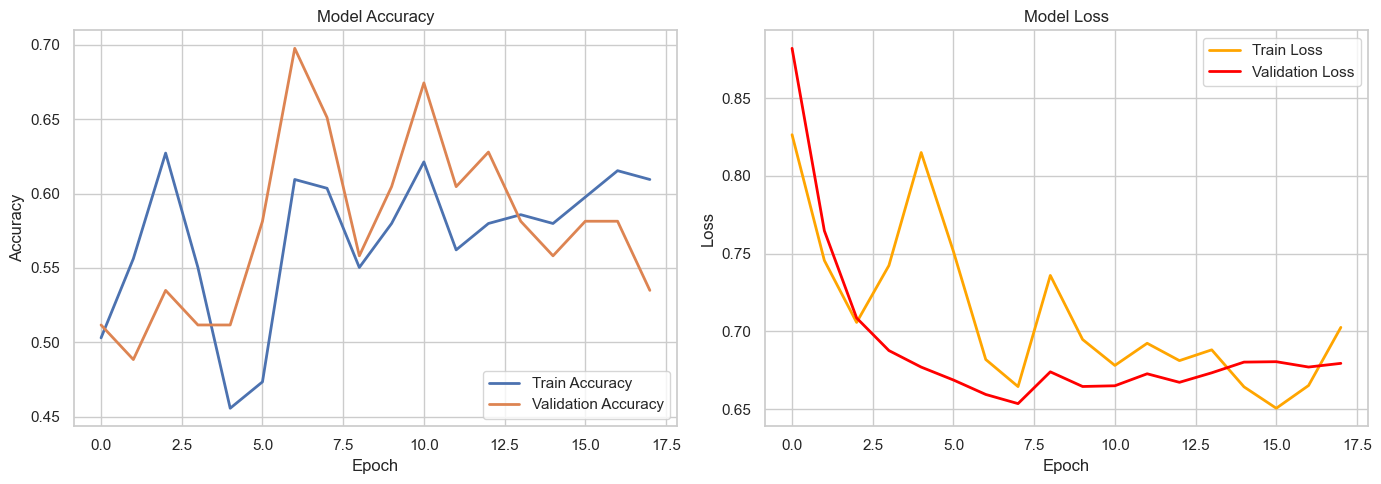

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Final Training Accuracy: 60.95%
Test Accuracy: 65.12%
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.79      0.67        19
           1       0.76      0.54      0.63        24

    accuracy                           0.65        43
   macro avg       0.67      0.67      0.65        43
weighted avg       0.68      0.65      0.65        43



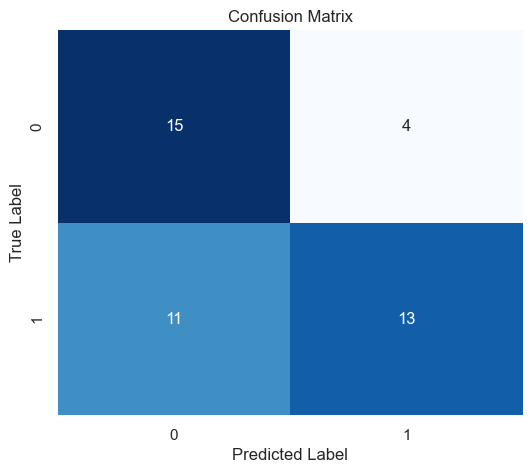

In [23]:
# 1. Enhanced Loss/Accuracy Curves
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2, color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('learning_curves.png')
plt.show()

# 2. Evaluation on Test Set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Access the training accuracy list from the history object
train_acc = history.history['accuracy']

# Print the final training accuracy (from the last epoch)
print(f"Final Training Accuracy: {train_acc[-1]*100:.2f}%")
print(f"Test Accuracy: {accuracy*100:.2f}%")
print("-" * 30)

# 3. Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 4. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png')
plt.show()

Cell 7: Predictions Analysis
Table showing 10 correct and 5 incorrect predictions.

In [16]:
# Create results dataframe
results_df = pd.DataFrame({'True_Label': y_test, 'Predicted_Label': y_pred})

# Filter correct and incorrect
correct_preds = results_df[results_df['True_Label'] == results_df['Predicted_Label']].head(10)
incorrect_preds = results_df[results_df['True_Label'] != results_df['Predicted_Label']].head(5)

print("--- 10 Correct Predictions ---")
print(correct_preds)
print("\n--- 5 Incorrect Predictions ---")
if not incorrect_preds.empty:
    print(incorrect_preds)
else:
    print("None found in the first batch.")

--- 10 Correct Predictions ---
    True_Label  Predicted_Label
0            0                0
2            1                1
3            0                0
4            0                0
6            0                0
9            0                0
11           1                1
12           1                1
13           0                0
15           1                1

--- 5 Incorrect Predictions ---
    True_Label  Predicted_Label
1            1                0
5            1                0
7            1                0
8            0                1
10           1                0
